# Nuclear Case Study - Double Loop Workflow

In this notebook, we illustrate the simulation of a base-load nuclear power plant integrated with a low temperature electrolysis system for hydrogen production using the double loop workflow. In addition to DISPATCHES, we need IDAES grid integration tools and Prescient. 

For a given integrated energy system, the double loop workflow has six key steps:
- Forecasting: Generate plausible price forcasts for the bidding horizon (chosen to be 48 hours).
- Bidding: Formulate and solve a multi-period bidding problem for the generated set of forcasted price signals. The solution of the bidding problem yields a time-varying bid curve.
- Day Ahead (DA) Market: Using the bid curve generated in the previous step, solve the unit commitment problem for the day ahead market.
- Real Time Market: Fix unit commitment decisions and solve the unit commitment problem for the real time market. The solution yields real time local marginal prices and the optimal dispatch profile for each generator.
- Tracking: Formulate and solve a tracking problem to track the optimal dispatch profile obtained in the previous step, and minimize the cost of production of electricity by minimizing the penalty associated with under-/over-production.
- Settlement: Compute all the cash flows

First, we import the required python packages, grid integration tools from IDAES, Prescient, and `MultiPeriodNuclear` class (defined in `nuclear_flowsheet_multiperiod_class.py` file). 

The `MultiPeriodNuclear` class generates a multi-period model of the base-load nuclear power plant integrated with a PEM electrolyzer and a hydrogen storage tank. The details related to the flowsheet model can be found in `nuclear_flowsheet_fixed_design.py`.

In [1]:
# Import general python packages
from types import ModuleType
from importlib import resources
import pathlib
import sys
import pandas as pd
import matplotlib.pyplot as plt

# Imports from the IDAES package
from idaes.apps.grid_integration import Tracker
from idaes.apps.grid_integration import Bidder
from idaes.apps.grid_integration import PlaceHolderForecaster
from idaes.apps.grid_integration import DoubleLoopCoordinator
# from idaes.apps.grid_integration.model_data import GeneratorModelData
from idaes.core.solvers import get_solver
from idaes.apps.grid_integration.model_data import (
    GeneratorModelData as _UpstreamGeneratorModelData,
    RealValueValidator,
    AtLeastPminValidator
)

# Import Prescient and the RTS-GMLC dataset
from prescient.simulator import Prescient
from dispatches_sample_data import rts_gmlc

# Import nuclear flowsheet
from nuclear_flowsheet_multiperiod_class import MultiPeriodNuclear

Interactive Python mode detected; using default matplotlib backend for plotting.


Next, we define a dictionary containing the generator data, and construct the `model_data` object using it. 

- `gen_name`: The id of the generator in the RTS - GMLC that is being replaced by the integrated energy system. There is only one nuclear generator (`121_NUCLEAR_1`) in the RTS - GMLC dataset, so `gen_name` = `121_NUCLEAR_1`
- `generator_type`: Accepts either `thermal` or `renewable`. We choose `thermal` for both fossil and nuclear generators
- `p_min`: Minimum power output to the grid (in MW). The capacity of the nuclear power plant is 500 MW and that of the PEM electrolyzer is 100 MW. Nuclear power plant is always operated at it base-load, so the minimum power output to the grid = 500 $-$ 100 = 400 MW
- `p_max`: Maximum power output to the grid (in MW). Power output is maximum when the PEM electrolyzer is turned off, and it is equal to base-load power output from the nuclear power plant i.e., 500 MW
- `min_down_time`: Mininum downtime after the generator is shutdown (chosen to be 48 hours)
- `min_up_time`: Minimum uptime after the generator is turned on (chosen to be 24 hours)
- `ramp_up_60min`: Ramp up rate (in MW/hr). Since the PEM electrolyzer is amenable for fast ramp up/ramp down, and for fast startup/shutdown, the ramp rate for the power output to the grid is the same as the capacity of the PEM electrolyzer i.e., 100 MW/hr
- `ramp_down_60min`: Ramp down rate (in MW/hr). Same as above.
- `shutdown_capacity`: Power output when shutdown is initiated (in MW). Since the nuclear power plant is always operated at base-load, the shutdown capacity is the same as the base-load value i.e., 500 MW
- `startup_capacity`: Power output when the generator is turned on. Same as above.
- `production_cost_bid_pairs`: Cost of production of electricity in \$/MW as function of power output i.e., (power output in MW, cost in \$/MW)
- `startup_cost_pairs`: (\# hours after shutdown, cost of startup)
- `fixed_commitment`: 0/1 indicates that plant shutdown is allowed/not allowed.

In [2]:
class GeneratorModelData(_UpstreamGeneratorModelData):
    p_min_agc = RealValueValidator(min_val=0)
    p_max_agc = AtLeastPminValidator()

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.p_min_agc = self.p_min
        self.p_max_agc = self.p_max
        

In [3]:
generator_data = {
    "gen_name": "121_NUCLEAR_1",
    "generator_type": "thermal",
    "p_min": 400,
    "p_max": 500,
    "min_down_time": 48,
    "min_up_time": 24,
    "ramp_up_60min": 100,
    "ramp_down_60min": 100,
    "shutdown_capacity": 500,
    "startup_capacity": 500,
    "production_cost_bid_pairs": [
        (400, 15),
        (450, 17.5),
        (500, 20),
    ],
    "startup_cost_pairs": [(48, 7355.42)],
    "fixed_commitment": 1
}

model_data = GeneratorModelData(**generator_data)

Next, we set the parameters needed for the double loop workflow

- `n_scenario`: Number of scenarios to be considered for the bidding problem. The file `idaes.apps.grid_integration.examples.lmp_forecasts_concat.csv` has data for ten scenarios, so we can choose any number between 1 and 10.
- `bidding_horizon`: Length of the bidding horizon. We choose it to be 48 hours.
- `tracking_horizon`: Length of the tracking horizon. We choose it to be 12 hours.
- `n_tracking_hour`: Frequency at which the tracking problem needs to be solved (every hour)
- `num_days`: Simulation horizon (number of days)

In [4]:
n_scenario = 3  # for bidding
bidding_horizon = 48  # hours
tracking_horizon = 12  # hours
n_tracking_hour = 1  # advance n_tracking_hour
num_days = 3

Import the forcast price data and create a solver objecct

In [5]:
# Import the forcasted price data
with resources.open_text("idaes.apps.grid_integration.examples", "lmp_forecasts_concat.csv") as f:
    forecasts_df = pd.read_csv(f)
forecaster = PlaceHolderForecaster(price_forecasts_df=forecasts_df)

# Create the solver object
solver = get_solver()

Create bidder, tracker and coordinator objects using the IDAES grid integration tools `Bidder`, `Tracker` and `DoubleLoopCoordinator`

In [6]:
# Setup trackers, bidder, and coordinator
#################################################################################
# Tracker
mp_nuclear_tracker = MultiPeriodNuclear(
    horizon=tracking_horizon,
    model_data=model_data
)
nuclear_tracker = Tracker(
    tracking_model_object=mp_nuclear_tracker,
    n_tracking_hour=n_tracking_hour,
    solver=solver,
)

# Projection Tracker
mp_nuclear_projection_tracker = MultiPeriodNuclear(
    horizon=tracking_horizon,
    model_data=model_data
)
nuclear_projection_tracker = Tracker(
    tracking_model_object=mp_nuclear_projection_tracker,
    n_tracking_hour=n_tracking_hour,
    solver=solver,
)

# Bidder
mp_nuclear_bidder = MultiPeriodNuclear(
    horizon=bidding_horizon,
    model_data=model_data
)
nuclear_bidder = Bidder(
    bidding_model_object=mp_nuclear_bidder,
    n_scenario=n_scenario,
    solver=solver,
    forecaster=forecaster,
)

# Coordinator
coordinator = DoubleLoopCoordinator(
    bidder=nuclear_bidder,
    tracker=nuclear_tracker,
    projection_tracker=nuclear_projection_tracker,
)



2022-06-29 10:50:13 [INFO] idaes.init.fs.pem.outlet_state: Property package initialization: optimal - Optimal Solution Found.
2022-06-29 10:50:14 [INFO] idaes.init.fs.pem.outlet_state: Property package initialization: optimal - Optimal Solution Found.
2022-06-29 10:50:14 [INFO] idaes.init.fs.pem.outlet_state: Property package initialization: optimal - Optimal Solution Found.
2022-06-29 10:50:15 [INFO] idaes.init.fs.pem.outlet_state: Property package initialization: optimal - Optimal Solution Found.
2022-06-29 10:50:16 [INFO] idaes.init.fs.pem.outlet_state: Property package initialization: optimal - Optimal Solution Found.
2022-06-29 10:50:16 [INFO] idaes.init.fs.pem.outlet_state: Property package initialization: optimal - Optimal Solution Found.
2022-06-29 10:50:17 [INFO] idaes.init.fs.pem.outlet_state: Property package initialization: optimal - Optimal Solution Found.
2022-06-29 10:50:18 [INFO] idaes.init.fs.pem.outlet_state: Property package initialization: optimal - Optimal Solution

Create a plugin for the double loop simulation

In [7]:
# Create a class to create the plugin
class PrescientPluginModule(ModuleType):
    def __init__(self, get_configuration, register_plugins):
        self.get_configuration = get_configuration
        self.register_plugins = register_plugins


plugin_module = PrescientPluginModule(
    get_configuration=coordinator.get_configuration,
    register_plugins=coordinator.register_plugins,
)

Set Prescient options and run double loop simulation

**IMPORTANT** Before proceeding with the rest of the notebook:

1. Install the `dispatches-sample-data` package by running `pip install dispatches-sample-data` in the terminal

OR

1. Download the RTS-GMLC dataset from [this repository](https://github.com/GridMod/RTS-GMLC) (or directly as a zipfile [here](https://github.com/GridMod/RTS-GMLC/archive/refs/heads/master.zip)) to your local machine
2. Update the value of the `rst_gmlc_data_dir` variable in the cell below to the appropriate location of the `RTS_Data/SourceData` subfolder on your local machine.

In [8]:
# Folder containing the RTS - GMLC data
rts_gmlc_data_dir = str(rts_gmlc.source_data_path)

# Set Prescient options
options = {
    "data_path": rts_gmlc_data_dir,
    "input_format": "rts-gmlc",
    "simulate_out_of_sample": True,
    "run_sced_with_persistent_forecast_errors": True,
    "output_directory": "bidding_multiperiod_nulcear",
    "start_date": "2020-07-10",
    "num_days": num_days,
    "sced_horizon": tracking_horizon,
    "ruc_horizon": bidding_horizon,
    "compute_market_settlements": True,
    "day_ahead_pricing": "LMP",
    "ruc_mipgap": 0.01,
    "symbolic_solver_labels": True,
    "reserve_factor": 0.0,
    "deterministic_ruc_solver": "gurobi",
    "output_ruc_solutions": True,
    "sced_solver": "gurobi",
    "print_sced": True,
    "enforce_sced_shutdown_ramprate": True,
    "plugin": {
        "doubleloop": {
            "module": plugin_module,
            "bidding_generator": "121_NUCLEAR_1",
        }
    },
}

# Run Prescient
Prescient().simulate(**options)

Initializing simulation...
Did not find reserves.csv; assuming no reserves


c:\Users\Radhakrishna\Anaconda3\lib\site-packages\pandas\io\parsers.py:3339: FutureWarning: 
        Use pd.to_datetime instead.

  return generic_parser(date_parser, *date_cols)


Setting default t0 state in RTS-GMLC parser
Dates to simulate: 2020-07-10 to 2020-07-12
RUC activation hours: 0
Final RUC date: 2020-07-12
Using current day's forecasts for RUC solves
Using persistent forecast error model when projecting demand and renewables in SCED


Extracting scenario to simulate
Ipopt 3.13.2: nlp_scaling_method=gradient-based
tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was com

## Analyze Results

First, we look at the results of the tracking problem i.e., whether the power sold to the grid matches with the power the nuclear plant is required to dispatch. These results are stored in `tracker_detail.csv` file in the newly created `bidding_multiperiod_nuclear` folder.

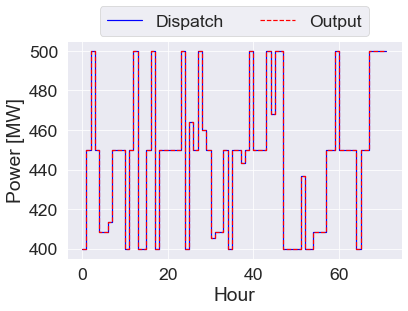

In [9]:
# Add the new folder containing the results to the path
sys.path.append(str(pathlib.Path().resolve()) + "\\bidding_multiperiod_nuclear")

# Read the results and generate the plot
track_df = pd.read_csv("tracker_detail.csv")
hour = []
power_dispatch = []
power_output = []
for i in range(int(len(track_df["Power Dispatch [MW]"]) / tracking_horizon)):
    hour.append(i)
    power_dispatch.append(track_df["Power Dispatch [MW]"][tracking_horizon * i])
    power_output.append(track_df["Power Output [MW]"][tracking_horizon * i])

plt.plot(hour, power_dispatch, color='blue',
            drawstyle='steps', label="Dispatch")
plt.plot(hour, power_output, '--', color='red',
            drawstyle='steps', label="Output")
plt.xlabel("Hour")
plt.ylabel("Power [MW]")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2)
plt.show()

Clearly, integrating the nuclear power plant with a low temperature electrolysis unit increases the flexibility of the power output from the nuclear power plant to the grid. And, the integrated system is able to track the optimal dispatch profile. Next, we plot amount of hydrogen sold to the market as a function of time, and the variation of tank holdup as a function of time.

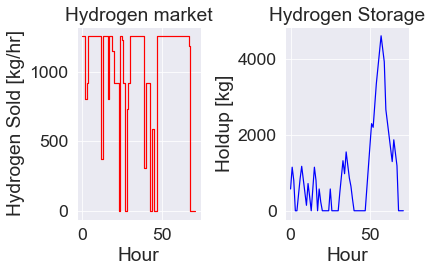

In [10]:
track_df = pd.read_csv("tracking_model_detail.csv")
hour = []
h2_market = []
h2_storage = []

for i in range(int(len(track_df["Power to Grid [MW]"]) / tracking_horizon)):
    hour.append(i)
    h2_market.append(track_df["Hydrogen Market [kg/hr]"][tracking_horizon * i])
    h2_storage.append(track_df["Final holdup [kg]"][tracking_horizon * i])

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(hour, h2_market, color='red', drawstyle='steps')
ax1.set_title(f"Hydrogen market")
ax1.set_xlabel("Hour")
ax1.set_ylabel("Hydrogen Sold [kg/hr]")

ax2.plot(hour, h2_storage, color="blue")
ax2.set_title("Hydrogen Storage")
ax2.set_xlabel("Hour")
ax2.set_ylabel("Holdup [kg]")
fig.tight_layout()
plt.show()


Here, the rate of hydrogen production can be much higher than the rate at which it can be sold to the market. Therefore, the excess hydrogen produced during the periods of low LMP (locational marginal price) is stored in the tank, and sold to the market at a later time when the LMP is high. 

The remaining results in the `bidding_multiperiod_nuclear` folder can be imported and analyzed in a similar manner.